In [1]:
import warnings
warnings.filterwarnings("ignore")

from google.cloud import bigquery
client = bigquery.Client()
import pandas as pd

# data processing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# metrics and evaluation
from xgboost import plot_importance
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
num_folds = 10
seed = 7

# visualization 
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Tahoma','DejaVu Sans','Lucida Grande','Verdana']

import warnings
warnings.filterwarnings("ignore")

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Selecting the data for teachers with "Freemium" subscription plan after 7 days of their first day of activity.
<br>
Then Selecting the data for teachers with "Premium" subscription plan after 7 days of their first day of activity.
<br>
This means that for the classification problem we have only two classes: 0 - freemium and 1 - preemium labels. This allows us approaching the classification problem as a binary one.

In [2]:
sql_freemium = """
SELECT
account_created_dayofyear, total_students, xp, hp, random_event, random_picker, message, power_usage, gear_equipping, gear_item_purchase, per_training, level_up, discussion_comment, CASE WHEN label = "freemium" THEN 0 ELSE 1 END AS label
FROM `classcraft-dev.Ilya_OVS_dataset.train_data_2w`
WHERE label = "freemium"
"""
df_freemium = client.query(sql_freemium).to_dataframe()
print("number of data entries: ", df_freemium.shape)

number of data entries:  (8939, 14)


In [3]:
sql_preemium = """
SELECT
account_created_dayofyear, total_students, xp, hp, random_event, random_picker, message, power_usage, gear_equipping, gear_item_purchase, per_training, level_up, discussion_comment, CASE WHEN label = "freemium" THEN 0 ELSE 1 END AS label 
FROM `classcraft-dev.Ilya_OVS_dataset.train_data_2w`
WHERE label <> "freemium"
"""
df_preemium = client.query(sql_preemium).to_dataframe()
print("number of data entries: ", df_preemium.shape)

number of data entries:  (1865, 14)


**Down-sample Majority (freemium) Class**
<br>
The number of data entries with the label 1 (premium) is 1350, so we need to downsample the Majority class (0 - freemium) so it matches the size of the Minority class (1 - premium).
 <br>
**Resample function:**
<br>
replace: Implements resampling with replacement. If False, this will implement (sliced) random permutations.
random_state: The seed of the pseudo random number generator to use when shuffling the data.

In [4]:
num_features = df_freemium.shape[1] - 1
print ("num_features: ", num_features)
dataset_freemium_downsampled = resample(df_freemium, 
                                 replace=False, # sample without replacement
                                 n_samples=df_preemium.shape[0], # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
dataset_balanced = pd.concat([dataset_freemium_downsampled, df_preemium])
#converting the balanced DataFrame into a Numpy Array:
array_all_data_balanced = dataset_balanced.as_matrix()

# splitting data into a X - observations and Y - labels 
X = array_all_data_balanced[:,0:num_features]
Y = array_all_data_balanced[:,num_features]

num_instances = len(X)
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)

num_features:  13


**Data Split**

In [5]:
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

**XGBoost classifier**

Initializing the model and fitting the data into the model

In [6]:
model = XGBClassifier(base_score=0.5, 
                      colsample_bylevel=1, 
                      colsample_bytree=1,
                      gamma=0, 
                      learning_rate=0.1, 
                      max_delta_step=0, 
                      max_depth=3,
                      min_child_weight=1, 
                      missing=None, 
                      n_estimators=100, 
                      nthread=-1,
                      objective='binary:logistic', 
                      reg_alpha=0, 
                      reg_lambda=1,
                      scale_pos_weight=1, 
                      seed=0, 
                      silent=True, 
                      subsample=1)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

1.Making predictions as .predict() to get actual labels for all data entries (in our case 0 or 1 for freemium and premium)
<br>
2.Making predictions as .predict_proba() to get probabilities of each label for all data entries (the sum of two brobabilities is always 1)

In [7]:
predictions = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

**Logistic Regression classifier**

Initializing the model and fitting the data into the model

In [8]:
clf = LogisticRegression(C=1.0, 
                         class_weight=None, 
                         dual=False, 
                         fit_intercept=True,
                         intercept_scaling=1, 
                         max_iter=100, 
                         multi_class='multinomial',
                         n_jobs=1, 
                         penalty='l2', 
                         random_state=0, 
                         solver='lbfgs',
                         tol=0.0001, 
                         verbose=0, 
                         warm_start=False)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

1.Making predictions as .predict() to get actual labels for all data entries (in our case 0 or 1 for freemium and premium)
<br>
2.Making predictions as .predict_proba() to get probabilities of each label for all data entries (the sum of two brobabilities is always 1)

In [9]:
reg_predicted = clf.predict(X_test)
reg_predicted_proba = clf.predict_proba(X_test)

**AUC - ROC Curve.**
<br>
<br>
AUC - Area Under The Curve 
ROC - Receiver Operating Characteristics) curve. 
<br>
AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. 
ROC is a probability curve and AUC represents degree or measure of separability. 
It tells how much model is capable of distinguishing between classes. 
Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.


In [10]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba[:,1])
roc_auc = metrics.auc(fpr, tpr)

fpr_logreg, tpr_logreg, threshold = metrics.roc_curve(y_test, reg_predicted_proba[:,1])
roc_auc_logreg = metrics.auc(fpr_logreg, tpr_logreg)


**Visualizing Accuary scores, Features Importance and ROC curves for XGBoost and Logistic Regression models:**

Accuracy for XGBoost Classifier: 90.21%
XGBoost K-fold cross-validation Accuracy: 89.79%
Confusion matrix for XGBoost classifier:
[[362  28]
 [ 45 311]]


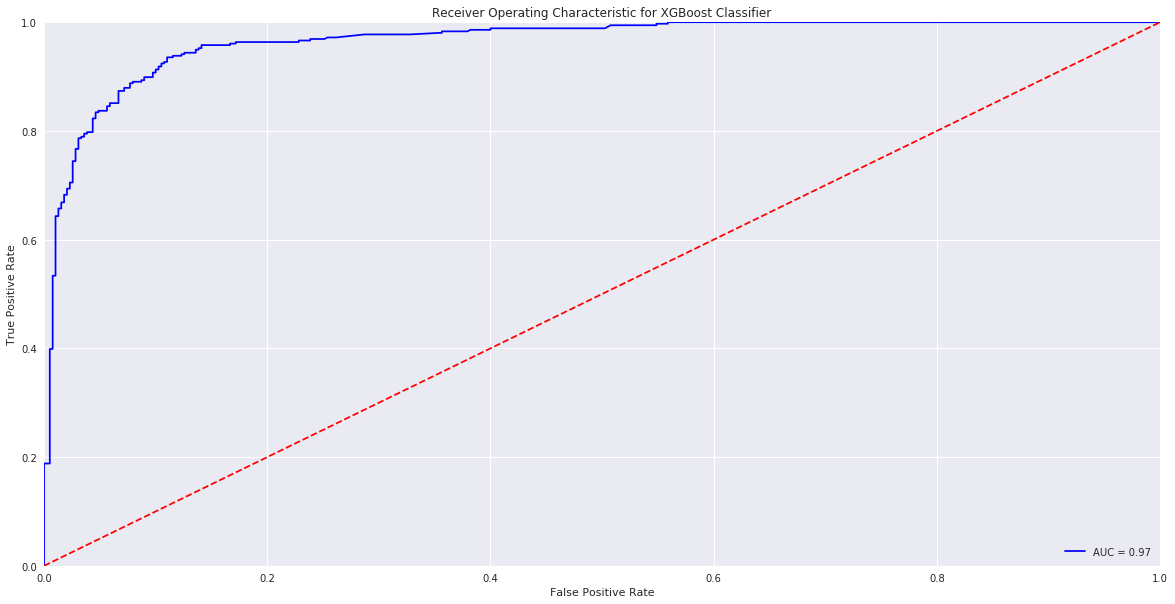

0 account_created_dayofyear
1 total_students
2 xp
3 hp
4 random_event
5 random_picker
6 message
7 power_usage
8 gear_equipping
9 gear_item_purchase
10 per_training
11 level_up
12 discussion_comment
13 label


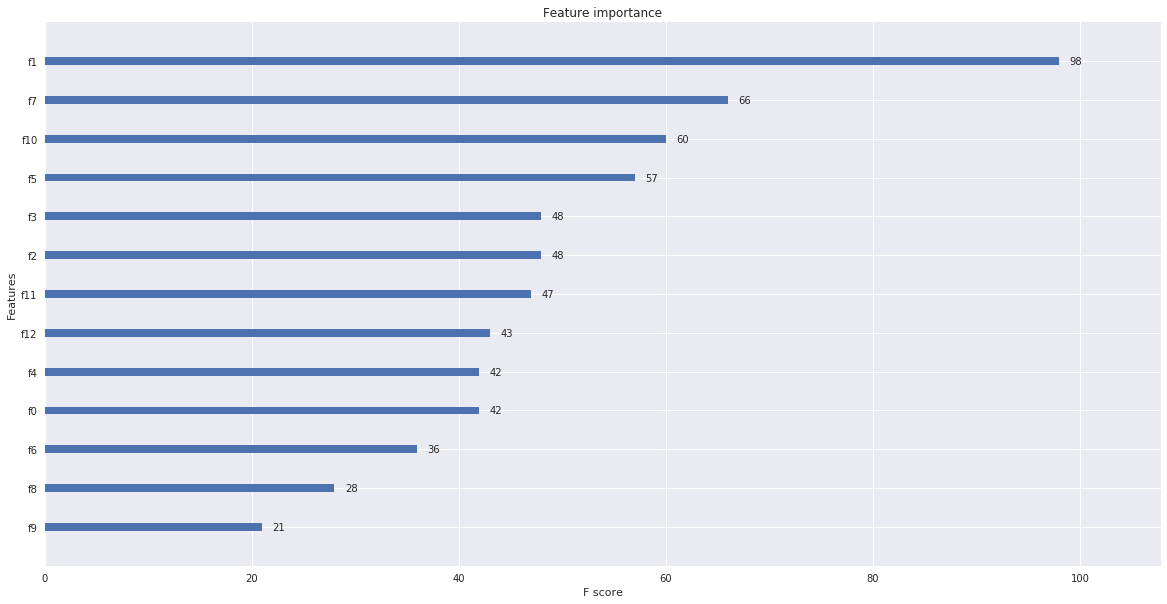

Accuracy for Logistic Regression: 85.79%
Logistic Regression K-fold cross-validation Accuracy: 84.13%
Confusion matrix for Logistic Regression classifier:
[[369  21]
 [ 85 271]]


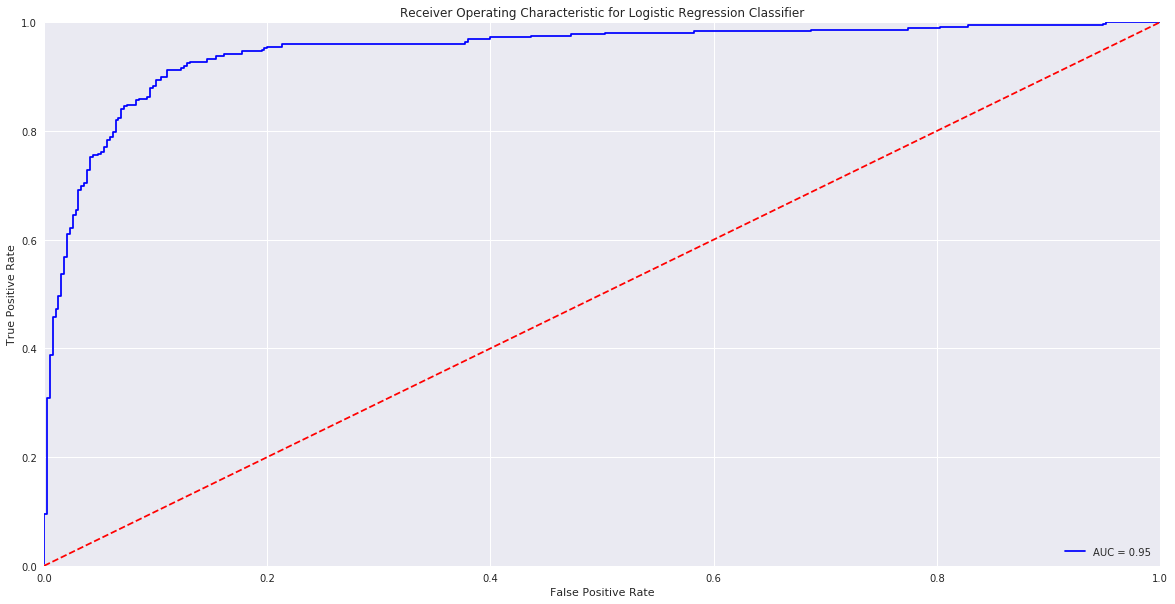

In [11]:

# evaluate predictions for XGBoost
xgb_accuracy = accuracy_score(y_test, predictions)
print("Accuracy for XGBoost Classifier: %.2f%%" % (xgb_accuracy * 100.0))


# evaluate predictions for XGBoost with K-fold cross-validation score:
results = cross_validation.cross_val_score(model, X, Y, cv=kfold)
print("XGBoost K-fold cross-validation Accuracy: %.2f%%" % (results.mean()*100.0))


# confusion matrix for XGBoost clasifier
XGBoost_conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion matrix for XGBoost classifier:")
print (XGBoost_conf_matrix)


plt.figure(figsize=(20,10))
plt.title('Receiver Operating Characteristic for XGBoost Classifier')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

for idx, val in enumerate(df_freemium.columns):
  print(idx, val)

ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(20,10)
plt.show()
#################################################################################################
# evaluate predictions for Logistic Regression
reg_accuracy = accuracy_score(y_test, reg_predicted)
print("Accuracy for Logistic Regression: %.2f%%" % (reg_accuracy * 100.0))


# evaluate predictions for Logistic Regression with K-fold cross-validation score:
results = cross_validation.cross_val_score(clf, X, Y, cv=kfold)
print("Logistic Regression K-fold cross-validation Accuracy: %.2f%%" % (results.mean()*100.0))

# confusion matrix for Logistic Regression clasifier
reg_conf_matrix = confusion_matrix(y_test, reg_predicted)
print("Confusion matrix for Logistic Regression classifier:")
print (reg_conf_matrix)


plt.figure(figsize=(20,10))
plt.title('Receiver Operating Characteristic for Logistic Regression Classifier')
plt.plot(fpr_logreg, tpr_logreg, 'b', label = 'AUC = %0.2f' % roc_auc_logreg)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()
pyplot.show()

**Bayesian event-based predictive model**
<br>
<br>
Customer intent is modeled using a supervised learning algorithm, which uses historical data to learn patterns of user behavior. 
<br>
<br>
The Naïve Bayesian algorithm, which uses a statistical approach and is based on the Bayes Theorem of the probability of event occurrence, has gained popularity because it’s suitable for classifying or predicting multiple outcomes, each associated with a propensity score. 
<br>
<br>
The Bayesian approach is robust and less likely to find false patterns in noisy data (“over-fit” the data).

Accuracy for Naive Bayes Classifier: 75.74%
K-fold cross-validation Accuracy: 73.81%
Confusion matrix for NBC classifier:
[[376  14]
 [167 189]]


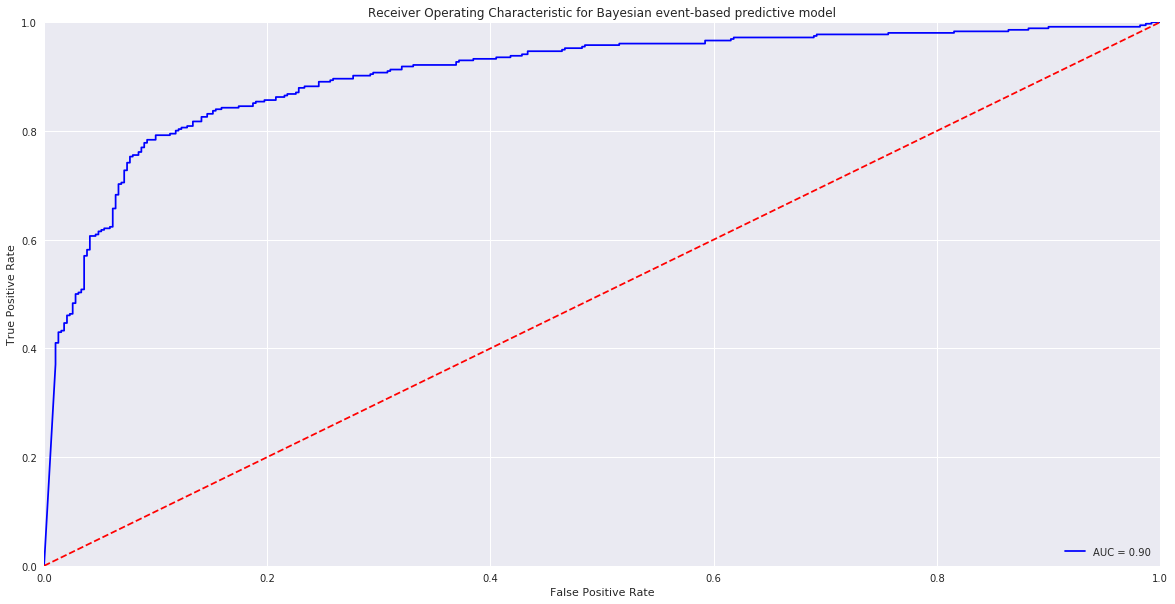

In [12]:
# Gaussian Naive Bayes Classification
NBC = GaussianNB()
NBC.fit(X_train, y_train)
NBC_predicted = NBC.predict(X_test)
NBC_predicted_proba = NBC.predict_proba(X_test)


# evaluate predictions for NBC with train and test data:
NBC_accuracy = accuracy_score(y_test, NBC_predicted)
print("Accuracy for Naive Bayes Classifier: %.2f%%" % (NBC_accuracy * 100.0))

# evaluate predictions for NBC with K-fold cross-validation score:
results = cross_validation.cross_val_score(NBC, X, Y, cv=kfold)
print("K-fold cross-validation Accuracy: %.2f%%" % (results.mean()*100.0))

# confusion matrix for NBC clasifier
NBC_conf_matrix = confusion_matrix(y_test, NBC_predicted)
print("Confusion matrix for NBC classifier:")
print (NBC_conf_matrix)

fpr_naive, tpr_naive, threshold = metrics.roc_curve(y_test, NBC_predicted_proba[:,1])
roc_auc_naive = metrics.auc(fpr_naive, tpr_naive)


plt.figure(figsize=(20,10))
plt.title('Receiver Operating Characteristic for Bayesian event-based predictive model')
plt.plot(fpr_naive, tpr_naive, 'b', label = 'AUC = %0.2f' % roc_auc_naive)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



